# Logistic Regression and Neural Network

Initial setup for this notebook

In [1]:
# Setup code for this notebook
import random 
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic gto make matplotlib figures appear inline
# in the notebook rather than in a new window
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

We are using the cifar-10 dataset for Python

The following function loads the data inside each batch

In [2]:
import _pickle as pickle
import numpy as np
import os

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = pickle.load(f, encoding="latin1")
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

Initial pre-processing

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def get_CIFAR10_data(num_training=49000, num_val=1000, num_test=10000, show_sample=True):
    """
    Load the CIFAR-10 dataset, and divide the sample into training set, validation set and test set
    """

    cifar10_dir = '../T2/cifar/'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # subsample the data for validation set
    mask = range(num_training, num_training + num_val)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    return X_train, y_train, X_val, y_val, X_test, y_test

def visualize_sample(X_train, y_train, classes, samples_per_class=7):
    """visualize some samples in the training datasets """
    num_classes = len(classes)
    for y, cls in enumerate(classes):
        idxs = np.flatnonzero(y_train == y) # get all the indexes of cls
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs): # plot the image one by one
            plt_idx = i * num_classes + y + 1 # i*num_classes and y+1 determine the row and column respectively
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(X_train[idx].astype('uint8'))
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.show()
    
def preprocessing_CIFAR10_data(X_train, y_train, X_val, y_val, X_test, y_test):
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1)) # [49000, 3072]
    X_val = np.reshape(X_val, (X_val.shape[0], -1)) # [1000, 3072]
    X_test = np.reshape(X_test, (X_test.shape[0], -1)) # [10000, 3072]
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    
    # Add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]).T
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]).T
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]).T
    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above functions to get our data
X_train_raw, y_train_raw, X_val_raw, y_val_raw, X_test_raw, y_test_raw = get_CIFAR10_data()
#visualize_sample(X_train_raw, y_train_raw, classes)

X_train, y_train, X_val, y_val, X_test, y_test = preprocessing_CIFAR10_data(X_train_raw, y_train_raw, X_val_raw, y_val_raw, X_test_raw, y_test_raw)

# As a sanity check, we print out th size of the training and test data dimenstion
print ('Train data shape: ', X_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Train data shape:  (3073, 49000)
Train labels shape:  (49000,)
Validation data shape:  (3073, 1000)
Validation labels shape:  (1000,)
Test data shape:  (3073, 10000)
Test labels shape:  (10000,)


Defining the function to apply logistic regression

In [4]:
def loss_grad_logistic_naive(W, X, y, reg):
    """
    Compute the loss and gradients using logistic function 
    with loop, which is slow.
    Parameters
    ----------
    W: (1, D) array of weights, D is the dimension of one sample.
    X: (D, N) array of training data, each column is a training sample with D-dimension.
    y: (N, ) 1-dimension array of target data with length N.
    reg: (float) regularization strength for optimization.
    Returns
    -------
    a tuple of two items (loss, grad)
    loss: (float)
    grad: (array) with respect to self.W
    """
    dim, num_train = X.shape
    loss = 0
    grad = np.zeros_like(W) # [1, D]
    for i in range(num_train):
        sample_x = X[:, i]
        f_x = 0
        for idx in range(sample_x.shape[0]):
            f_x += W[0, idx] * sample_x[idx]
        h_x = 1.0 / (1 + np.exp(-f_x))
        loss += y[i] * np.log(h_x) + (1 - y[i]) * np.log(1 - h_x)

        grad += (h_x - y[i]) * sample_x # [D, ]
    loss /= -num_train
    loss += 0.5 * reg * np.sum(W * W) # add regularization

    grad /= num_train
    grad += reg * W # add regularization
    return loss, grad

def loss_grad_logistic_vectorized(W, X, y, reg):
    """Compute the loss and gradients with weights, vectorized version"""
    dim, num_train = X.shape
    loss = 0
    grad = np.zeros_like(W) # [1, D]
    # print W
    f_x_mat = W.dot(X) # [1, D] * [D, N]
    h_x_mat = 1.0 / (1.0 + np.exp(-f_x_mat)) # [1, N]
    loss = np.sum(y * np.log(h_x_mat) + (1 - y) * np.log(1 - h_x_mat))
    loss = -1.0 / num_train * loss + 0.5 * reg * np.sum(W * W)
    grad = (h_x_mat - y).dot(X.T) # [1, D]
    grad = 1.0 / num_train * grad + reg * W
    
    return loss, grad

In [5]:
# Set the label of the first class to be one, and 0 for others
from copy import deepcopy
y_train_test_loss = deepcopy(y_train)
idxs_zero = y_train_test_loss == 0
y_train_test_loss[idxs_zero] = 1
y_train_test_loss[-idxs_zero] = 0

# Test the loss and gradient and compare between two implementations
import time

# generate a rand weights W 
W = np.random.randn(1, X_train.shape[0]) * 0.001
tic = time.time()
loss_naive, grad_naive = loss_grad_logistic_naive(W, X_train, y_train_test_loss, 0)
toc = time.time()
print ("Naive loss: %f, and gradient: computed in %fs" % (loss_naive, toc - tic))

tic = time.time()
loss_vec, grad_vect = loss_grad_logistic_vectorized(W, X_train, y_train_test_loss, 0)
toc = time.time()
print ("Vectorized loss: %f, and gradient: computed in %fs" % (loss_vec, toc - tic))

# Compare the gradient, because the gradient is a vector, we canuse the Frobenius norm to compare them
# the Frobenius norm of two matrices is the square root of the squared sum of differences of all elements
diff = np.linalg.norm(grad_naive - grad_vect, ord='fro')
# Randomly choose some gradient to check
idxs = np.random.choice(X_train.shape[0], 10, replace=False)
print (idxs)
print (grad_naive[0, idxs])
print (grad_vect[0, idxs])
print ("Gradient difference between naive and vectorized version is: %f" % diff)
del loss_naive, loss_vec, grad_naive, y_train_test_loss

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.
  


Naive loss: 1.385601, and gradient: computed in 61.110490s
Vectorized loss: 1.385601, and gradient: computed in 0.165448s
[2693 2307 1753 1704 1864   87  452 2826  667 1229]
[  1.25106992   3.80055876  -2.55370414   1.51396641  -4.85823422
  10.0128126    2.74323992   3.19256856   7.42340688  -0.92320913]
[  1.25106992   3.80055876  -2.55370414   1.51396641  -4.85823422
  10.0128126    2.74323992   3.19256856   7.42340688  -0.92320913]
Gradient difference between naive and vectorized version is: 0.000000


In [6]:
# file: algorithms/gradient_check.py
def grad_check_sparse(f, x, analytic_grad, num_checks):
  """
  sample a few random elements and only return numerical
  in this dimensions.
  """
  h = 1e-5

  print (x.shape)

  for i in range(num_checks):
    ix = tuple([random.randrange(m) for m in x.shape])
    print (ix)
    x[ix] += h # increment by h
    fxph = f(x) # evaluate f(x + h)
    x[ix] -= 2 * h # increment by h
    fxmh = f(x) # evaluate f(x - h)
    x[ix] += h # reset

    grad_numerical = (fxph - fxmh) / (2 * h)
    grad_analytic = analytic_grad[ix]
    rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
    print ("numerical: %f analytic: %f, relative error: %e" % (grad_numerical, grad_analytic, rel_error))
    
# Check gradient using numerical gradient along several randomly chosen dimenstion

f = lambda w: loss_grad_logistic_vectorized(w, X_train, y_train, 0)[0]
grad_numerical = grad_check_sparse(f, W, grad_vect, 10)

(1, 3073)
(0, 1008)
numerical: -1.373122 analytic: 6.917547, relative error: 1.000000e+00
(0, 1351)
numerical: 14.747438 analytic: 4.489653, relative error: 5.332295e-01
(0, 899)
numerical: 7.869460 analytic: 1.215485, relative error: 7.324178e-01
(0, 2919)
numerical: 16.769186 analytic: 3.765243, relative error: 6.332751e-01
(0, 2279)
numerical: 19.911130 analytic: -1.661651, relative error: 1.000000e+00
(0, 380)
numerical: -5.634660 analytic: 4.624132, relative error: 1.000000e+00
(0, 637)
numerical: 4.706409 analytic: 4.423459, relative error: 3.099168e-02
(0, 755)
numerical: 3.979925 analytic: 2.814849, relative error: 1.714665e-01
(0, 1034)
numerical: 8.815611 analytic: -0.272388, relative error: 1.000000e+00
(0, 776)
numerical: 8.367582 analytic: 6.155220, relative error: 1.523371e-01


In [7]:
class LinearClassifier:

    def __init__(self):
        self.W = None # set up the weight matrix 

    def train(self, X, y, method='sgd', batch_size=200, learning_rate=1e-4,
              reg = 1e3, num_iters=1000, verbose=False, vectorized=True):
        """
        Train linear classifer using batch gradient descent or stochastic gradient descent
        Parameters
        ----------
        X: (D x N) array of training data, each column is a training sample with D-dimension.
        y: (N, ) 1-dimension array of target data with length N.
        method: (string) determine whether using 'bgd' or 'sgd'.
        batch_size: (integer) number of training examples to use at each step.
        learning_rate: (float) learning rate for optimization.
        reg: (float) regularization strength for optimization.
        num_iters: (integer) number of steps to take when optimization.
        verbose: (boolean) if True, print out the progress (loss) when optimization.
        Returns
        -------
        losses_history: (list) of losses at each training iteration
        """

        dim, num_train = X.shape
        num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes

        if self.W is None:
            # initialize the weights with small values
            if num_classes == 2: # just need weights for one class
                self.W = np.random.randn(1, dim) * 0.001
            else: # weigths for each class
                self.W = np.random.randn(num_classes, dim) * 0.001

        losses_history = []

        for i in range(num_iters):
            if method == 'bgd':
                loss, grad = self.loss_grad(X, y, reg, vectorized)
            else:
                # randomly choose a min-batch of samples
                idxs = np.random.choice(num_train, batch_size, replace=False)
                loss, grad = self.loss_grad(X[:, idxs], y[idxs], reg, vectorized) # grad => [K x D]
            losses_history.append(loss)

            # update weights
            self.W -= learning_rate * grad # [K x D]
            # print self.W
            # print 'dsfad', grad.shape
            if verbose and (i % 100 == 0):
                print ("iteration %d/%d: loss %f" % (i, num_iters, loss))

        return losses_history

    def predict(self, X):
        """
        Predict value of y using trained weights
        Parameters
        ----------
        X: (D x N) array of data, each column is a sample with D-dimension.
        Returns
        -------
        pred_ys: (N, ) 1-dimension array of y for N sampels
        h_x_mat: Normalized scores
        """
        pred_ys = np.zeros(X.shape[1])
        f_x_mat = self.W.dot(X)
        if self.__class__.__name__ == 'Logistic':
            pred_ys = f_x_mat.squeeze() >=0
        else: # multiclassification
            pred_ys = np.argmax(f_x_mat, axis=0)
        # normalized score
        h_x_mat = 1.0 / (1.0 + np.exp(-f_x_mat)) # [1, N]
        h_x_mat = h_x_mat.squeeze()
        return pred_ys, h_x_mat

    def loss_grad(self, X, y, reg, vectorized=True):
        """
        Compute the loss and gradients.
        Parameters
        ----------
        The same as self.train()
        Returns
        -------
        a tuple of two items (loss, grad)
        loss: (float)
        grad: (array) with respect to self.W
        """
        pass


# Subclasses of linear classifier
class Logistic(LinearClassifier):
    """A subclass for binary classification using logistic function"""
    def loss_grad(self, X, y, reg, vectorized=True):
        if vectorized:
            return loss_grad_logistic_vectorized(self.W, X, y, reg)
        else:
            return loss_grad_logistic_naive(self.W, X, y, reg)


class Softmax(LinearClassifier):
    """A subclass for multi-classicication using Softmax function"""
    def loss_grad(self, X, y, reg, vectorized=True):
        if vectorized:
            return loss_grad_softmax_vectorized(self.W, X, y, reg)
        else:
            return loss_grad_softmax_naive(self.W, X, y, reg)


class SVM(LinearClassifier):
    """A subclass for multi-classicication using SVM function"""
    def loss_grad(self, X, y, reg, vectorized=True):
        return loss_grad_svm_vectorized(self.W, X, y, reg)

In [8]:

logistic_classifiers = []
num_classes = np.max(y_train) + 1
losses = []
for i in range(num_classes):
    print ("\nThe %d/%dth logistic classifier training..." % (i+1, num_classes))
    y_train_logistic = deepcopy(y_train)
    idxs_i = y_train_logistic == i
    y_train_logistic[idxs_i] = 1
    y_train_logistic[-idxs_i] = 0
    logistic = Logistic()
    loss = logistic.train(X_train, y_train_logistic, method='sgd', batch_size=200, learning_rate=1e-6,
              reg = 1e3, num_iters=1000, verbose=True, vectorized=True)
    losses.append(loss)
    logistic_classifiers.append(logistic)


The 1/10th logistic classifier training...
iteration 0/1000: loss 2.698755


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.
  # Remove the CWD from sys.path while we load stuff.


iteration 100/1000: loss 2.065364
iteration 200/1000: loss 1.741361
iteration 300/1000: loss 1.529838
iteration 400/1000: loss 1.316915
iteration 500/1000: loss 1.205001
iteration 600/1000: loss 1.149513
iteration 700/1000: loss 0.988679
iteration 800/1000: loss 0.964064
iteration 900/1000: loss 0.906054

The 2/10th logistic classifier training...
iteration 0/1000: loss 2.882417
iteration 100/1000: loss 1.982794
iteration 200/1000: loss 1.756199
iteration 300/1000: loss 1.561229
iteration 400/1000: loss 1.400618
iteration 500/1000: loss 1.214982
iteration 600/1000: loss 1.132236
iteration 700/1000: loss 1.023040
iteration 800/1000: loss 0.947547
iteration 900/1000: loss 0.904932

The 3/10th logistic classifier training...
iteration 0/1000: loss 3.017153
iteration 100/1000: loss 2.084206
iteration 200/1000: loss 1.793964
iteration 300/1000: loss 1.504417
iteration 400/1000: loss 1.370568
iteration 500/1000: loss 1.221945
iteration 600/1000: loss 1.117426
iteration 700/1000: loss 1.06442

D:\Anaconda3\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
D:\Anaconda3\lib\site-packages\ggplot\stats\smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
D:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


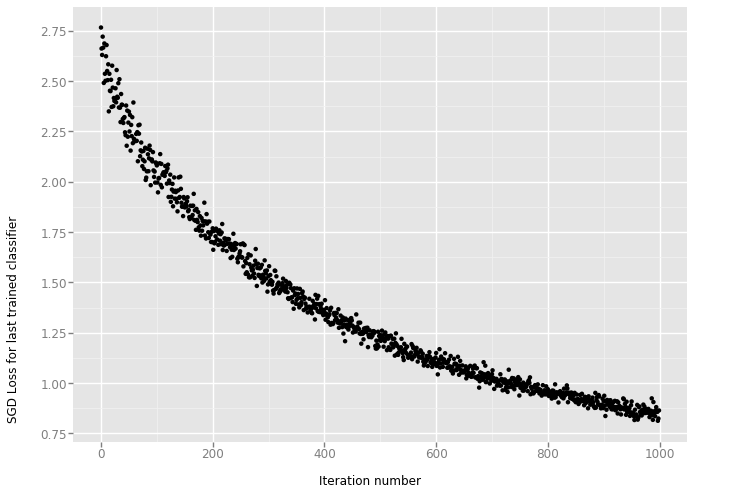

<ggplot: (-9223371908453552503)>

In [9]:
from ggplot import *
# plot the loss of the last trained logistic classifier
qplot(range(len(losses[9])), losses[9]) + labs(x='Iteration number', y='SGD Loss for last trained classifier')

In [10]:
# Compute the accuracy of training data and validation data
def predict_one_vs_all(logistic_classifiers, X, num_classes):
    scores = np.zeros((num_classes, X.shape[1]))
    for i in range(num_classes):
        logistic = logistic_classifiers[i]
        scores[i, :] = logistic.predict(X)[1]
    pred_X = np.argmax(scores, axis=0)
    return pred_X

pred_train_one_vs_all = predict_one_vs_all(logistic_classifiers, X_train, num_classes)
pred_val_one_vs_all = predict_one_vs_all(logistic_classifiers, X_val, num_classes)
pred_test_one_vs_all = predict_one_vs_all(logistic_classifiers, X_test, num_classes)
print ("Training dataset accuracy: %f" % (np.mean(y_train == pred_train_one_vs_all)))
print ("Validation dataset accuracy: %f" % (np.mean(y_val == pred_val_one_vs_all)))
print ("Test datast accuracy: %f" % (np.mean(y_test == pred_test_one_vs_all)))

Training dataset accuracy: 0.338224
Validation dataset accuracy: 0.351000
Test datast accuracy: 0.331100


In [11]:
# file: algorithms/classifiers/loss_grad_softmax.py
import numpy as np

def loss_grad_softmax_naive(W, X, y, reg):
    """
    Compute the loss and gradients using softmax function 
    with loop, which is slow.
    Parameters
    ----------
    W: (K, D) array of weights, K is the number of classes and D is the dimension of one sample.
    X: (D, N) array of training data, each column is a training sample with D-dimension.
    y: (N, ) 1-dimension array of target data with length N with lables 0,1, ... K-1, for K classes
    reg: (float) regularization strength for optimization.
    Returns
    -------
    a tuple of two items (loss, grad)
    loss: (float)
    grad: (K, D) with respect to W
    """
    loss = 0
    grad = np.zeros_like(W)
    dim, num_train = X.shape
    num_classes = W.shape[0]
    for i in range(num_train):
        sample_x = X[:, i]
        scores = np.zeros(num_classes) # [K, 1] unnormalized score
        for cls in range(num_classes):
            w = W[cls, :]
            scores[cls] = w.dot(sample_x)
        # Shift the scores so that the highest value is 0
        scores -= np.max(scores)
        correct_class = y[i]
        sum_exp_scores = np.sum(np.exp(scores))

        corr_cls_exp_score = np.exp(scores[correct_class])
        loss_x = -np.log(corr_cls_exp_score / sum_exp_scores)
        loss += loss_x

        # compute the gradient
        percent_exp_score = np.exp(scores) / sum_exp_scores
        for j in range(num_classes):
            grad[j, :] += percent_exp_score[j] * sample_x


        grad[correct_class, :] -= sample_x # deal with the correct class

    loss /= num_train
    loss += 0.5 * reg * np.sum(W * W) # add regularization
    grad /= num_train
    grad += reg * W
    return loss, grad

def loss_grad_softmax_vectorized(W, X, y, reg):
    """ Compute the loss and gradients using softmax with vectorized version"""
    loss = 0 
    grad = np.zeros_like(W)
    dim, num_train = X.shape

    scores = W.dot(X) # [K, N]
    # Shift scores so that the highest value is 0
    scores -= np.max(scores)
    scores_exp = np.exp(scores)
    correct_scores_exp = scores_exp[y, range(num_train)] # [N, ]
    scores_exp_sum = np.sum(scores_exp, axis=0) # [N, ]
    loss = -np.sum(np.log(correct_scores_exp / scores_exp_sum))
    loss /= num_train
    loss += 0.5 * reg * np.sum(W * W)

    scores_exp_normalized = scores_exp / scores_exp_sum
    # deal with the correct class
    scores_exp_normalized[y, range(num_train)] -= 1 # [K, N]
    grad = scores_exp_normalized.dot(X.T)
    grad /= num_train
    grad += reg * W

    return loss, grad

In [12]:
# generate a rand weights W 
W = np.random.randn(10, X_train.shape[0]) * 0.001
tic = time.time()
loss_naive, grad_naive = loss_grad_softmax_naive(W, X_train, y_train, 0.0001)
toc = time.time()
print ("Naive loss: %f, and gradient: computed in %fs" % (loss_naive, toc - tic))

tic = time.time()
loss_vec, grad_vect = loss_grad_softmax_vectorized(W, X_train, y_train, 0.0001)
toc = time.time()
print ("Vectorized loss: %f, and gradient: computed in %fs" % (loss_vec, toc - tic))

# Compare the gradient, because the gradient is a vector, we canuse the Frobenius norm to compare them
# the Frobenius norm of two matrices is the square root of the squared sum of differences of all elements
diff = np.linalg.norm(grad_naive - grad_vect, ord='fro')
# Randomly choose some gradient to check
idxs = np.random.choice(X_train.shape[0], 10, replace=False)
print (idxs)
print (grad_naive[0, idxs])
print (grad_vect[0, idxs])
print ("Gradient difference between naive and vectorized version is: %f" % diff)
del loss_naive, loss_vec, grad_naive

Naive loss: 6.221538, and gradient: computed in 3.899368s
Vectorized loss: 6.221538, and gradient: computed in 0.170453s
[3020 1027 1874  485  329  558 2369 1042 2098 1672]
[-7.33878828 -2.50394184 -4.32875319 -3.64524178 -4.92517243  0.16006863
 -8.28531784 -1.63295044 -6.45780613 -2.59133083]
[-7.33878828 -2.50394184 -4.32875319 -3.64524178 -4.92517243  0.16006863
 -8.28531784 -1.63295044 -6.45780613 -2.59133083]
Gradient difference between naive and vectorized version is: 0.000000


In [13]:
def grad_check_sparse(f, x, analytic_grad, num_checks):
  """
  sample a few random elements and only return numerical
  in this dimensions.
  """
  h = 1e-5

  print (x.shape)

  for i in range(num_checks):
    ix = tuple([random.randrange(m) for m in x.shape])
    print (ix)
    x[ix] += h # increment by h
    fxph = f(x) # evaluate f(x + h)
    x[ix] -= 2 * h # increment by h
    fxmh = f(x) # evaluate f(x - h)
    x[ix] += h # reset

    grad_numerical = (fxph - fxmh) / (2 * h)
    grad_analytic = analytic_grad[ix]
    rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
    print ("numerical: %f analytic: %f, relative error: %e" % (grad_numerical, grad_analytic, rel_error))

In [14]:
# Check gradient using numerical gradient along several randomly chosen dimenstion
f = lambda w: loss_grad_softmax_vectorized(w, X_train, y_train, 0)[0]
grad_numerical = grad_check_sparse(f, W, grad_vect, 10)

(10, 3073)
(2, 1320)
numerical: -0.962993 analytic: -0.962993, relative error: 3.071797e-08
(4, 3016)
numerical: -0.507678 analytic: -0.507679, relative error: 1.224353e-07
(1, 1954)
numerical: 3.804140 analytic: 3.804140, relative error: 2.498974e-09
(9, 359)
numerical: -9.530497 analytic: -9.530497, relative error: 8.034080e-09
(7, 329)
numerical: -2.749351 analytic: -2.749351, relative error: 3.482173e-09
(2, 2369)
numerical: 0.612546 analytic: 0.612547, relative error: 1.643499e-07
(1, 278)
numerical: -3.644120 analytic: -3.644120, relative error: 2.335230e-08
(5, 651)
numerical: 5.164037 analytic: 5.164037, relative error: 1.294487e-08
(4, 2566)
numerical: 0.326029 analytic: 0.326029, relative error: 4.608299e-07
(1, 865)
numerical: -1.069318 analytic: -1.069318, relative error: 5.187793e-08


In [15]:
# # using BGD algorithm
# softmax_bgd = Softmax()
# tic = time.time()
# losses_bgd = softmax_bgd.train(X_train, y_train, method='bgd', batch_size=200, learning_rate=1e-6,
#               reg = 1e2, num_iters=1000, verbose=True, vectorized=True)
# toc = time.time()
# print 'Traning time for BGD with vectorized version is %f \n' % (toc - tic)

# # Compute the accuracy of training data and validation data using Softmax.predict function
# y_train_pred_bgd = softmax_bgd.predict(X_train)[0]
# print 'Training accuracy: %f' % (np.mean(y_train == y_train_pred_bgd))
# y_val_pred_bgd = softmax_bgd.predict(X_val)[0]
# print 'Validation accuracy: %f' % (np.mean(y_val == y_val_pred_bgd))

# # using SGD algorithm
softmax_sgd = Softmax()
tic = time.time()
losses_sgd = softmax_sgd.train(X_train, y_train, method='sgd', batch_size=200, learning_rate=1e-6,
              reg = 1e5, num_iters=1000, verbose=True, vectorized=True)
toc = time.time()
print ("Traning time for SGD with vectorized version is %f \n" % (toc - tic))

y_train_pred_sgd = softmax_sgd.predict(X_train)[0]
print ("Training accuracy: %f" % (np.mean(y_train == y_train_pred_sgd)))
y_val_pred_sgd = softmax_sgd.predict(X_val)[0]
print ("Validation accuracy: %f" % (np.mean(y_val == y_val_pred_sgd)))

iteration 0/1000: loss 1525.296801
iteration 100/1000: loss 2.132342
iteration 200/1000: loss 2.167871
iteration 300/1000: loss 2.152555
iteration 400/1000: loss 2.143142
iteration 500/1000: loss 2.211829
iteration 600/1000: loss 2.156675
iteration 700/1000: loss 2.144379
iteration 800/1000: loss 2.148133
iteration 900/1000: loss 2.191718
Traning time for SGD with vectorized version is 4.315476 

Training accuracy: 0.277939
Validation accuracy: 0.298000


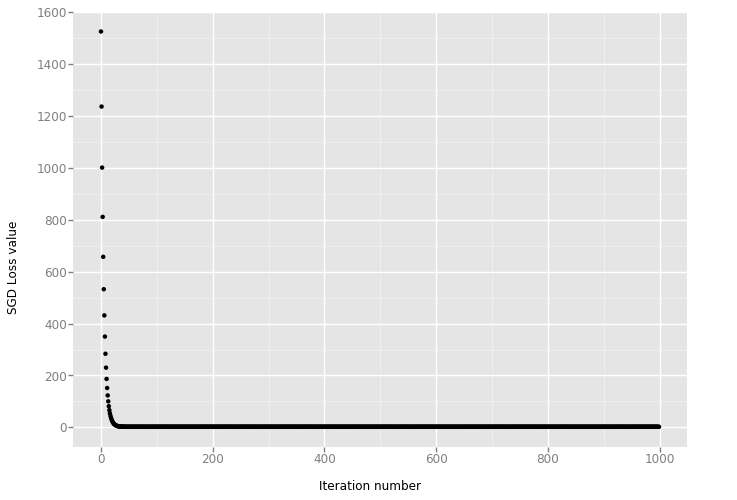

<ggplot: (-9223371908453502625)>

In [16]:
from ggplot import *
qplot(range(len(losses_sgd)), losses_sgd) + labs(x='Iteration number', y='SGD Loss value')

In [17]:
# Using validation set to tuen hyperparameters, i.e., learning rate and regularization strength
learning_rates = [1e-5, 1e-8]
regularization_strengths = [10e2, 10e4]

# Result is a dictionary mapping tuples of the form (learning_rate, regularization_strength) 
# to tuples of the form (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1
best_softmax = None
# Choose the best hyperparameters by tuning on the validation set
i = 0
interval = 5
for learning_rate in np.linspace(learning_rates[0], learning_rates[1], num=interval):
    i += 1
    print ("The current iteration is %d/%d" % (i, interval))
    for reg in np.linspace(regularization_strengths[0], regularization_strengths[1], num=interval):
        softmax = Softmax()
        softmax.train(X_train, y_train, method='sgd', batch_size=200, learning_rate=learning_rate,
              reg = reg, num_iters=1000, verbose=False, vectorized=True)
        y_train_pred = softmax.predict(X_train)[0]
        y_val_pred = softmax.predict(X_val)[0]
        train_accuracy = np.mean(y_train == y_train_pred)
        val_accuracy = np.mean(y_val == y_val_pred)
        results[(learning_rate, reg)] = (train_accuracy, val_accuracy)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = softmax
        else:
            pass

# Print out the results
for learning_rate, reg in sorted(results):
    train_accuracy,val_accuracy = results[(learning_rate, reg)]
    print ("learning rate %e and regularization %e, \n \
    the training accuracy is: %f and validation accuracy is: %f.\n" % (learning_rate, reg, train_accuracy, val_accuracy))

The current iteration is 1/5
The current iteration is 2/5
The current iteration is 3/5
The current iteration is 4/5
The current iteration is 5/5
learning rate 1.000000e-08 and regularization 1.000000e+03, 
     the training accuracy is: 0.154184 and validation accuracy is: 0.144000.

learning rate 1.000000e-08 and regularization 2.575000e+04, 
     the training accuracy is: 0.135347 and validation accuracy is: 0.134000.

learning rate 1.000000e-08 and regularization 5.050000e+04, 
     the training accuracy is: 0.155245 and validation accuracy is: 0.170000.

learning rate 1.000000e-08 and regularization 7.525000e+04, 
     the training accuracy is: 0.178673 and validation accuracy is: 0.171000.

learning rate 1.000000e-08 and regularization 1.000000e+05, 
     the training accuracy is: 0.148388 and validation accuracy is: 0.137000.

learning rate 2.507500e-06 and regularization 1.000000e+03, 
     the training accuracy is: 0.400735 and validation accuracy is: 0.400000.

learning rate 2

In [18]:
y_test_predict_result = best_softmax.predict(X_test)
y_test_predict = y_test_predict_result[0]
test_accuracy = np.mean(y_test == y_test_predict)
print ("The test accuracy is: %f" % test_accuracy)

The test accuracy is: 0.390600


In [19]:
def sigmoid(z):
    return 1/(1+np.exp(-z))
def relu(z):
    return np.maximum(0, z)
def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

Training a neural network with 1 hidden layer with 2000 neurons

Taking 3500 steps to train the model

In [37]:

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [21]:
import tensorflow as tf


config = tf.contrib.learn.RunConfig(tf_random_seed=42) # not shown in the config

feature_cols = tf.contrib.learn.infer_real_valued_columns_from_input(X_train)
dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units=[2000], n_classes=10, feature_columns=feature_cols, config=config)
dnn_clf = tf.contrib.learn.SKCompat(dnn_clf) # if TensorFlow >= 1.1
dnn_clf.fit(X_train, y_train, batch_size=50, steps=3500)

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001DE682CD7F0>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'C:\\Users\\Akira\\AppData\\Local\\Temp\\tmp5jmjqb78'}
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer suppor

SKCompat()

In [48]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test)
y_pred['classes'] = y_pred['classes'].shape(3073,1)
accuracy_score(y_test, y_pred['classes'])

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'report_uninitialized_variables_1/boolean_mask/Gather:0' shape=(?,) dtype=string>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "D:\\Anaconda3\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "D:\\Anaconda3\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "D:\\Anaconda3\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "D:\\Anaconda3\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "D:\\Anaconda3\\lib\\site-packages\\ipykernel\\kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "D:\\Anaconda3\\lib\\site-packages\\zmq\\eventloop\\ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).

INFO:tensorflow:Restoring parameters from C:\Users\Akira\AppData\Local\Temp\tmp5jmjqb78\model.ckpt-3500


InvalidArgumentError: tensor_name = dnn/hiddenlayer_0/weights; shape in shape_and_slice spec [10000,2000] does not match the shape stored in checkpoint: [49000,2000]
	 [[Node: save/RestoreV2_1 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save/Const_0_0, save/RestoreV2_1/tensor_names, save/RestoreV2_1/shape_and_slices)]]

Caused by op 'save/RestoreV2_1', defined at:
  File "D:\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "D:\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "D:\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "D:\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "D:\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "D:\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "D:\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "D:\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "D:\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "D:\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "D:\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "D:\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "D:\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "D:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "D:\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-48-1a86901d1f36>", line 3, in <module>
    y_pred = dnn_clf.predict(X_test)
  File "D:\Anaconda3\lib\site-packages\tensorflow\contrib\learn\python\learn\estimators\estimator.py", line 1383, in predict
    iterate_batches=True))
  File "D:\Anaconda3\lib\site-packages\tensorflow\contrib\learn\python\learn\estimators\estimator.py", line 893, in _infer_model
    config=self._session_config))
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\training\monitored_session.py", line 668, in __init__
    stop_grace_period_secs=stop_grace_period_secs)
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\training\monitored_session.py", line 490, in __init__
    self._sess = _RecoverableSession(self._coordinated_creator)
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\training\monitored_session.py", line 842, in __init__
    _WrappedSession.__init__(self, self._create_session())
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\training\monitored_session.py", line 847, in _create_session
    return self._sess_creator.create_session()
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\training\monitored_session.py", line 551, in create_session
    self.tf_sess = self._session_creator.create_session()
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\training\monitored_session.py", line 416, in create_session
    self._scaffold.finalize()
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\training\monitored_session.py", line 207, in finalize
    self._saver = training_saver._get_saver_or_default()  # pylint: disable=protected-access
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 733, in _get_saver_or_default
    saver = Saver(sharded=True, allow_empty=True)
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 1140, in __init__
    self.build()
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 1172, in build
    filename=self._filename)
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 684, in build
    restore_sequentially, reshape)
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 450, in _AddShardedRestoreOps
    name="restore_shard"))
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 407, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 247, in restore_op
    [spec.tensor.dtype])[0])
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_io_ops.py", line 663, in restore_v2
    dtypes=dtypes, name=name)
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): tensor_name = dnn/hiddenlayer_0/weights; shape in shape_and_slice spec [10000,2000] does not match the shape stored in checkpoint: [49000,2000]
	 [[Node: save/RestoreV2_1 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save/Const_0_0, save/RestoreV2_1/tensor_names, save/RestoreV2_1/shape_and_slices)]]


In [ ]:
from sklearn.metrics import log_loss

y_pred_proba = y_pred['probabilities']
log_loss(y_test, y_pred_proba)